# NEWS SCRAPER MINI PROJECT - MODELING

> The purpose of this notebook is to create and compare between 2 models to determine which is better to predict the the scraped news article data that has previously been scraped.
>
> The content of this notebook will consist of 6 parts:
>
> - **1. IMPORT LIBRARIES** - Importing the necessary libraries.
> - **2. OVERVIEW** - Conducting initial data sanity checks (info, null values, etc.).
> - **3. PREPROCESSING** - Sentiment analysis using 2 sentiment lexicon methods, and also target labeling.
> - **4. SIMPLE VISUALIZATION** - Visualization by counting words and wordcloud to better understand the dataset.
> - **5. MODELING** - Simple modeling pipeline without any tweaks using SVM and XGB models.
> - **6. EVALUATION** - Model evaluation using standard classification report and confusion matrix.
> - **7. CONCLUSION** - Summary of the project.
>
> In conclusion, this notebook demonstrates the process of creating and evaluating two models for predicting the sentiment of scraped news articles. However, further experimentation and hyperparameter tuning may be necessary to improve the performance of the models.\
> Overall, this project provides a foundation for future sentiment analysis projects using similar article data.

## IMPORT LIBRARIES

In [1]:
# data wrangling
import numpy as np
import pandas as pd
import string
import re
import html2text
from tqdm import tqdm

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# nlp wrangling
import nltk
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

# warning
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=FutureWarning)

## OVERVIEW
> After importing the necessary libraries, we will check the initial data state, summary and general data overview.\
> In this section, we will breakdown the data and try to see whether the data is clean enough to move to the next process.

In [2]:
# load data
df = pd.read_csv("data/kompas_news_clean.csv")

In [3]:
# show head
df.head()

,author,publish_date_adj,news_article_html_clean,news_article_token,news_article_stem
0,Tito Hilmawan Reditya,2023-04-26 18:15:00,"LONDON, KOMPAS.com Invasi China ke Taiwan dise...","['london', 'invasi', 'china', 'taiwan', 'mengh...",london invasi china taiwan hancur dagang dunia...
1,Aditya Jaya Iswara,2023-04-26 17:35:00,"BANGKOK, KOMPAS.com Polisi Thailand pada Selas...","['bangkok', 'polisi', 'thailand', 'selasa', 'm...",bangkok polisi thailand selasa tangkap istri p...
2,Danur Lambang Pristiandaru,2023-04-26 16:01:00,"PRETORIA, KOMPAS.com – Presiden Afrika Selatan...","['pretoria', '–', 'presiden', 'afrika', 'selat...",pretoria presiden afrika selatan cyril ramaph...
3,Aditya Jaya Iswara,2023-04-26 15:34:00,"WELLINGTON, KOMPAS.com Mantan Perdana Menteri ...","['wellington', 'mantan', 'perdana', 'menteri',...",wellington mantan perdana menteri selandia jac...
4,Aditya Jaya Iswara,2023-04-26 14:48:00,"MOSKWA, KOMPAS.com Rusia mengganti KFC yang ke...","['moskwa', 'rusia', 'mengganti', 'kfc', 'invas...",moskwa rusia ganti kfc invasi negara ukraina p...


In [4]:
# drop location on first stemmed string
drop_loc=[]
for i in df["news_article_stem"]:
    drop_loc.append(' '.join(i.split()[1:]))

In [5]:
# apply to dataframe
df["news_article_stem"] = drop_loc

In [6]:
# adjust publish_date_adj to datetime 
df["publish_date_adj"] = pd.to_datetime(df["publish_date_adj"])

In [7]:
# show head
df.head()

,author,publish_date_adj,news_article_html_clean,news_article_token,news_article_stem
0,Tito Hilmawan Reditya,2023-04-26 18:15:00,"LONDON, KOMPAS.com Invasi China ke Taiwan dise...","['london', 'invasi', 'china', 'taiwan', 'mengh...",invasi china taiwan hancur dagang dunia jarak ...
1,Aditya Jaya Iswara,2023-04-26 17:35:00,"BANGKOK, KOMPAS.com Polisi Thailand pada Selas...","['bangkok', 'polisi', 'thailand', 'selasa', 'm...",polisi thailand selasa tangkap istri polisi se...
2,Danur Lambang Pristiandaru,2023-04-26 16:01:00,"PRETORIA, KOMPAS.com – Presiden Afrika Selatan...","['pretoria', '–', 'presiden', 'afrika', 'selat...",presiden afrika selatan cyril ramaphosa negara...
3,Aditya Jaya Iswara,2023-04-26 15:34:00,"WELLINGTON, KOMPAS.com Mantan Perdana Menteri ...","['wellington', 'mantan', 'perdana', 'menteri',...",mantan perdana menteri selandia jacinda ardern...
4,Aditya Jaya Iswara,2023-04-26 14:48:00,"MOSKWA, KOMPAS.com Rusia mengganti KFC yang ke...","['moskwa', 'rusia', 'mengganti', 'kfc', 'invas...",rusia ganti kfc invasi negara ukraina produk l...


In [8]:
# show info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415 entries, 0 to 414
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   author                   415 non-null    object        
 1   publish_date_adj         415 non-null    datetime64[ns]
 2   news_article_html_clean  415 non-null    object        
 3   news_article_token       415 non-null    object        
 4   news_article_stem        415 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 16.3+ KB


In [9]:
# check null
df.isna().sum()

author                     0
publish_date_adj           0
news_article_html_clean    0
news_article_token         0
news_article_stem          0
dtype: int64

## PREPROCESSING

> In this part, we will create a sentiment analyzer using TextBlob and VADER, then label and store the data into main dataframe for the next process.

In [10]:
# function to create sentiment analyzer using TextBlob
def blob_scores(sentence):
    # use text blob and get polarity score
    blob     = TextBlob(sentence)
    blob     = blob.translate(from_lang="id", to="en") # translate to bahasa indonesia first
    blob_sen = blob.sentiment
    
    # set polarity threshold
    sen = []
    if blob_sen.polarity > 0 :
        sen.append('pos')
    else :
        sen.append('neg')
        
    return {"score":blob_sen.polarity, 
            "sentiment":sen}

In [11]:
# function to create sentiment analyzer using VADER
def vader_scores(sentence):
    # use sentiment intensity analyzer and get compound score
    sid     = SentimentIntensityAnalyzer()
    sid_sen = sid.polarity_scores(sentence)
    
    # set compound threshold
    sen = []
    if sid_sen['compound'] > 0 :
        sen.append("pos")
    else :
        sen.append("neg")
        
    return {"score":sid_sen["compound"], 
            "sentiment":sen}

In [12]:
# function to simplify the sentiment analyzer examination
def sentiment_sample_test(data, n_sample):
    print("Sample Sentences", "\n", "=="*50)
    for idx, sentence in enumerate(data.sample(n_sample)):
        print(f"\n sentence {idx+1}:")
        print("\n", sentence, "\n")
        print("text_blob score:", blob_scores(sentence))
        print("vader score    :", vader_scores(sentence))
        print("=="*50)

In [56]:
# examine sample to analyze the sentiment 
sentiment_sample_test(df["news_article_stem"], 5)

Sample Sentences 

 sentence 1:

 warna perang rusiaukraian jumat perdana menteri inggris rishi sunak kecam edar video penggal kepala tawan perang ukraina presiden rusia vladimir putin menandatangani undangundang cipta sistem pemberitahuan wajib militer elektronik digital jugarangkuman serang rusia ukraina klaim bakhmut bocor dokumen rahasia as kerja pangkal militer sistem laki laki rusia hindar program wajib militer lengkap rangkum serang rusia ukraina simak menteri negeri jerman annalena baerbock jumat desak china rusia henti perang ukraina bagus china isyarat komitmen solusi terang bertanyatanya posisi china masuk seru agresor rusia henti perang konferensi pers menlu china beijing temu kutip baerbock kunjung presiden china xi jinping barubaru moskwa negara milik pengaruh rusia china badan energi internasional iea jumat ekspor minyak rusia lonjak level tinggi maret sanksi barat invasi ukraina dapat rusia hitung turun tajam banding 

text_blob score: {'score': -0.0032499999999999985, 

In [14]:
# loop to dataframe
blob_sen  = []
vader_sen = []
for i in tqdm(df["news_article_stem"]):
    blob_sen.append(blob_scores(i)["sentiment"][0])
    vader_sen.append(vader_scores(i)["sentiment"][0])

100%|██████████| 415/415 [10:05<00:00,  1.46s/it]


In [15]:
# add new columns to df to store sentiment result
df["blob_sentiment"] = blob_sen
df["vader_sentiment"] = vader_sen

In [16]:
# labeling the target
df["blob_label"]  = [1 if i == "neg" else 0 for i in df["blob_sentiment"]]
df["vader_label"] = [1 if i == "neg" else 0 for i in df["vader_sentiment"]]

In [17]:
# show result
df.head()

,author,publish_date_adj,news_article_html_clean,news_article_token,news_article_stem,blob_sentiment,vader_sentiment,blob_label,vader_label
0,Tito Hilmawan Reditya,2023-04-26 18:15:00,"LONDON, KOMPAS.com Invasi China ke Taiwan dise...","['london', 'invasi', 'china', 'taiwan', 'mengh...",invasi china taiwan hancur dagang dunia jarak ...,pos,neg,0,1
1,Aditya Jaya Iswara,2023-04-26 17:35:00,"BANGKOK, KOMPAS.com Polisi Thailand pada Selas...","['bangkok', 'polisi', 'thailand', 'selasa', 'm...",polisi thailand selasa tangkap istri polisi se...,pos,neg,0,1
2,Danur Lambang Pristiandaru,2023-04-26 16:01:00,"PRETORIA, KOMPAS.com – Presiden Afrika Selatan...","['pretoria', '–', 'presiden', 'afrika', 'selat...",presiden afrika selatan cyril ramaphosa negara...,pos,neg,0,1
3,Aditya Jaya Iswara,2023-04-26 15:34:00,"WELLINGTON, KOMPAS.com Mantan Perdana Menteri ...","['wellington', 'mantan', 'perdana', 'menteri',...",mantan perdana menteri selandia jacinda ardern...,pos,pos,0,0
4,Aditya Jaya Iswara,2023-04-26 14:48:00,"MOSKWA, KOMPAS.com Rusia mengganti KFC yang ke...","['moskwa', 'rusia', 'mengganti', 'kfc', 'invas...",rusia ganti kfc invasi negara ukraina produk l...,pos,pos,0,0


## SIMPLE VISUALIZATION

> This section will add a simple data visualization to better understand the general perspective of the scraped news article.
>
> First we will check which author actually posted the most, and which posted the least, be that in all dataset, or on the negative sentiment only.\
> Then we will, see what is the most frequent word on these articles, so that we can get better understanding.

In [35]:
# split the dataframe according to vader's output, get only the negative
neg_df = df[df["vader_label"]!=1].reset_index(drop=True)

In [37]:
# function to visualize author data
def visualize_author(data, title):
    loc = data.value_counts()
    
    # start plot
    plt.figure(figsize=(12,6))
    ax = loc.plot(kind = 'barh')
    plt.tight_layout()

    for i, j in enumerate(loc):
        ax.text(j + 0.5, i, str(j))

    plt.title(title, fontsize=15)
    plt.show()

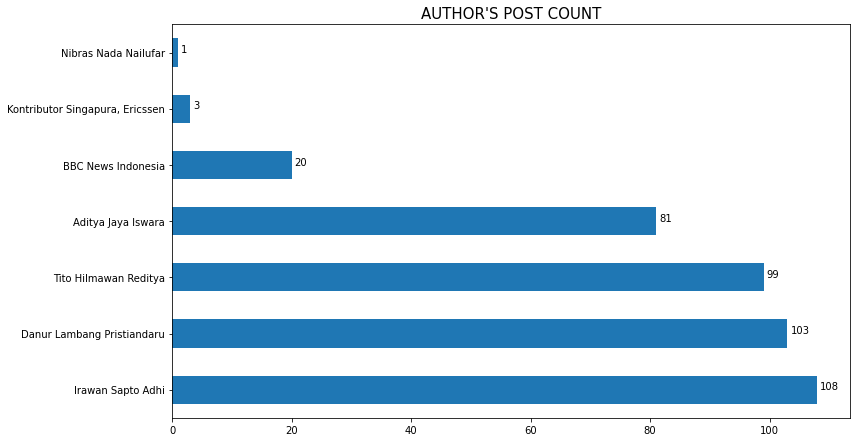

In [39]:
# visualize author count
visualize_author(df["author"], "AUTHOR'S POST COUNT")

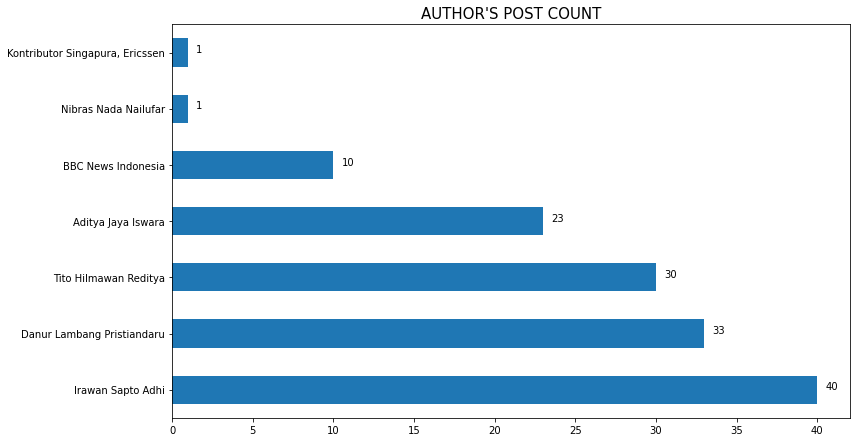

In [40]:
# visualize negative sentiment author
visualize_author(neg_df["author"], "AUTHOR'S POST COUNT")

In [53]:
# function to visualize word in article
def visualize_word(data, title):
    cv = CountVectorizer()
    words = cv.fit_transform(data)
    sum_words = words.sum(axis=0)
    words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    
    # start plot
    frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
    ax = frequency.head(15).plot(x='word', y='freq', kind='bar', figsize=(15, 7))

    for i in ax.patches:
            ax.annotate('{}'.format(i.get_height()), (i.get_x()+0.01, i.get_height()+8))

    plt.xticks(rotation=45)
    plt.title(title, fontsize=15)
    
    wordcloud = WordCloud(width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud)
    plt.title("WORDCLOUD VISUALIZATION", fontsize = 22)
    plt.show()
    plt.show()

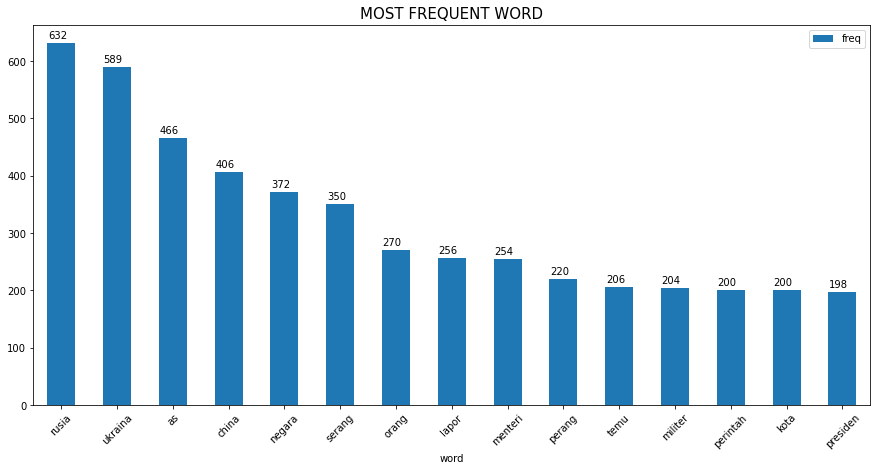

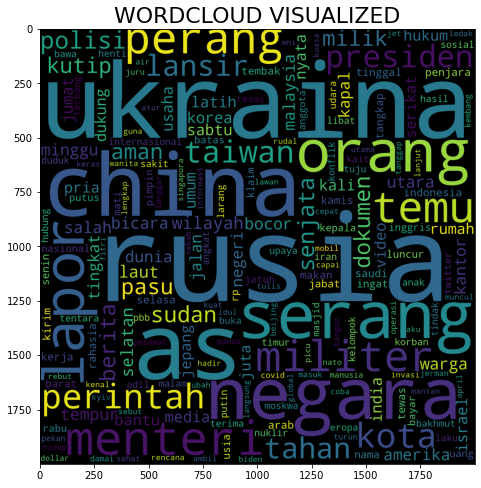

In [52]:
# visualize words in article
visualize_word(df["news_article_stem"], "MOST FREQUENT WORD")

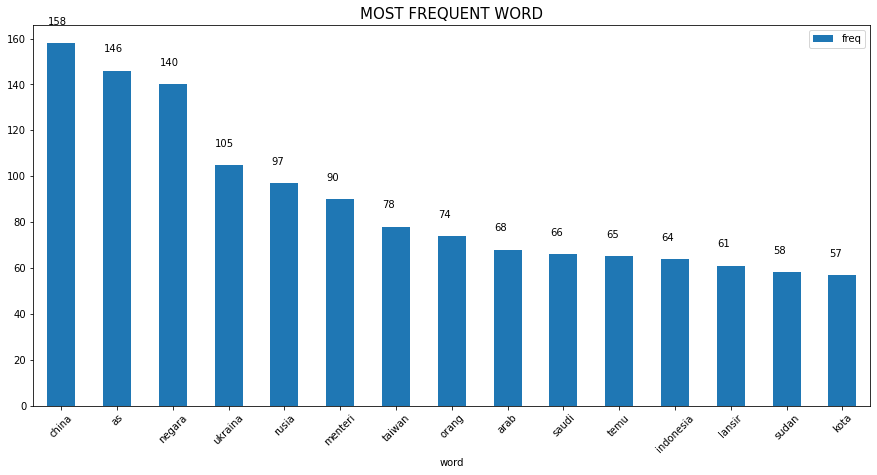

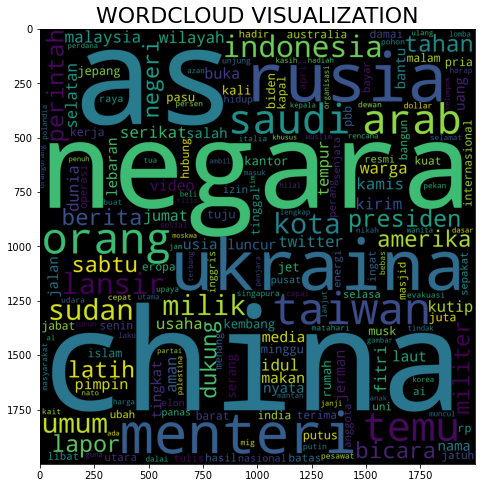

In [55]:
# visualize words in article (negative sentiment)
visualize_word(neg_df["news_article_stem"], "MOST FREQUENT WORD")

> From data visualization above, we can see that there are not much differences between the overall  (general) data and the negative sentiment only data.\
> Also interestingly, by counting the words we can get that the most frequent word is almost certainly about the current war in ukraine.\
> This represented by words such as **rusia, ukraina, china, serang, perang**, etc.

## MODELING

> In this section, we want to compare two models (SVM and XGB) with respect to each lexicon methods.

In [18]:
# function to ease the model pipeline process
def pipeline(X, y, model, test_size):
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # vectorize X train & test
    vect = CountVectorizer(ngram_range = (1,1))
    X_rep_train = vect.fit_transform(X_train) 
    X_rep_test = vect.transform(X_test)
    
    # model fit
    model = model
    model.fit(X_rep_train, y_train)
    
    # pred 
    y_pred = model.predict(X_rep_test)
    
    return {"y_test":y_test, 
            "y_pred": y_pred}

In [19]:
# function to plot confusion matrix and show classification report
def model_report(matrix, model_result, model_name, mehod_name):
    # plot confusion matrix
    f, ax = plt.subplots(figsize=(8,5))
    sns.heatmap(matrix, annot=True, fmt=".0f", ax=ax, cmap = 'Blues')
    
    labels = ["Positive", "Negative"]
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

    plt.title(f"Confusion Matrix of {model_name} Model using {mehod_name}")
    plt.xlabel("PREDICTED")
    plt.ylabel("ACTUAL")
    plt.show()

    # show classification report
    print(classification_report(model_result["y_test"], model_result["y_pred"], target_names = labels))

In [20]:
# set dependent and independent variable
X  = df["news_article_stem"]
yb = df["blob_label"] # textblob label
yv = df["vader_label"] # vader label

In [21]:
# set the models
SVM = LinearSVC(C=1)
XGB = XGBClassifier()

In [22]:
# pipeline model with 25% test size
## textblob
tb_SVM = pipeline(X, yb, SVM, 0.25)
tb_XGB = pipeline(X, yb, XGB, 0.25)

## vader
vd_SVM = pipeline(X, yv, SVM, 0.25)
vd_XGB = pipeline(X, yv, XGB, 0.25)

# confusion matrix for models
## textblob
cm_tb_SVM = confusion_matrix(tb_SVM["y_test"], tb_SVM["y_pred"])
cm_tb_XGB = confusion_matrix(tb_XGB["y_test"], tb_XGB["y_pred"])

##vader
cm_vd_SVM = confusion_matrix(vd_SVM["y_test"], vd_SVM["y_pred"])
cm_vd_XGB = confusion_matrix(vd_XGB["y_test"], vd_XGB["y_pred"])

## EVALUATION

> This part will evaluate the models, and compare the result between the models and how lexicon methods impact the model result.

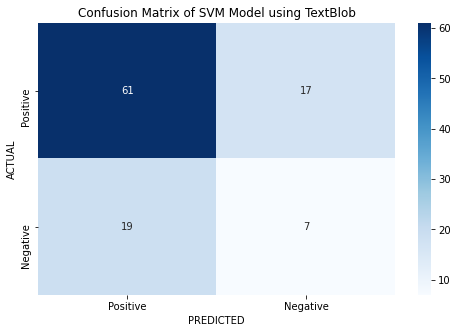

              precision    recall  f1-score   support

    Positive       0.76      0.78      0.77        78
    Negative       0.29      0.27      0.28        26

    accuracy                           0.65       104
   macro avg       0.53      0.53      0.53       104
weighted avg       0.64      0.65      0.65       104



In [23]:
# model eval SVM using textblob
model_report(cm_tb_SVM, tb_SVM, "SVM", "TextBlob")

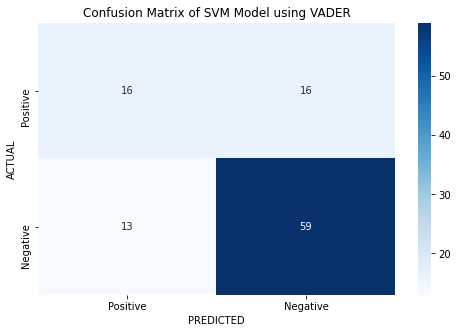

              precision    recall  f1-score   support

    Positive       0.55      0.50      0.52        32
    Negative       0.79      0.82      0.80        72

    accuracy                           0.72       104
   macro avg       0.67      0.66      0.66       104
weighted avg       0.71      0.72      0.72       104



In [24]:
# model eval SVM using vader
model_report(cm_vd_SVM, vd_SVM, "SVM", "VADER")

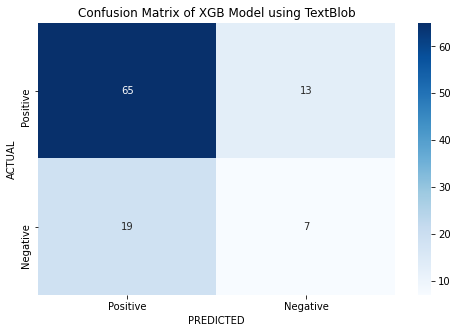

              precision    recall  f1-score   support

    Positive       0.77      0.83      0.80        78
    Negative       0.35      0.27      0.30        26

    accuracy                           0.69       104
   macro avg       0.56      0.55      0.55       104
weighted avg       0.67      0.69      0.68       104



In [25]:
# model eval XGB using textblob
model_report(cm_tb_XGB, tb_XGB, "XGB", "TextBlob")

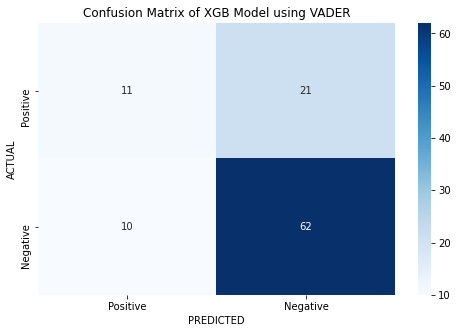

              precision    recall  f1-score   support

    Positive       0.52      0.34      0.42        32
    Negative       0.75      0.86      0.80        72

    accuracy                           0.70       104
   macro avg       0.64      0.60      0.61       104
weighted avg       0.68      0.70      0.68       104



In [26]:
# model eval XGB using vader
model_report(cm_vd_XGB, vd_XGB, "XGB", "VADER")

> The results show that both SVM and XGB models perform relatively well in classifying the articles into positive and negative sentiment categories. We also see that interestingly, the lexicon methods are the one who actually affected the results instead of the model algorithm itself. However, further experimentation and hyperparameter tuning may be necessary to prove this.

## CONCLUSION

> - In this project, we performed sentiment analysis on text data using two popular lexicon-based methods, TextBlob and VADER.
> 
> - Binary labels were generated based on the sentiment scores, with positive labeled as 0 and negative labeled as 1.
> 
> - Classification models were then trained using these labels and the performance of the models were compared. 
>
> - Interestingly, the results showed that the choice of sentiment analysis method had a greater impact on the classification performance than the choice of classification model. Therefore, no matter what kind of model we use, the result would not impacted significantly.
>
> - The TextBlob and VADER really had a significant different effects on the classification results. VADER outperformed TextBlob in detecting negative polarity, while TextBlob was biased towards positive sentiment.
>
> - Further experimentation and testing is needed to confirm the findings.